In [1]:
import pandas as pd
import numpy as np
import datetime
import tensorflow as tf
from tensorflow import keras
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import preprocessing
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle

#numpy配列を省略しないようにする
np.set_printoptions(threshold=np.inf)
#pandasを省略しないようにする
pd.set_option('display.max_columns', 500) # 列
pd.set_option('display.max_rows', 500)  # 行

mm = preprocessing.MinMaxScaler()  # 正規化エンコード、デコード

In [2]:
# 正規化関数
def mmscaler(data):
    mm = preprocessing.MinMaxScaler()  # 正規化エンコード、デコード
    dat = mm.fit_transform(data)
    return dat

# 目的変数の作成関数 1:df 2:目的変数のカラム名称 3:shiftさせるカラム名称 4:shiftする数
def shift(df, t_name, t_column, shift):
    df[t_name] = df[t_column].shift(shift) # 1行上にずらして5分後の値にしている
    return df

# トレーニングデータの作成
def create_data(read_dir, save_dir):
    df = pd.read_csv(read_dir, encoding='shift_jis')
    #カラムを削除
    df = df.dropna()  # NaNを削除
    #df.drop(labels='日付(ローソク足)', axis=1, inplace=True) # ろうそく足データの日付
    
    df['time'] = pd.to_datetime(df['time']  )#, format='%Y-%m-%d-%A %H:%M:%S')  # 日付カラムを日付型に変換
    df['time(hour)'] = df['time'].dt.hour  # hourをデータに追加
    df['time(minute)'] = df['time'].dt.minute  # minuteをデータに追加
    df['time(weekday)'] = df['time'].dt.dayofweek  # minuteをデータに追加
    # df['日付']カラムが [datetime64[ns]]型になっていて扱いづらいので最後に削除する
    #df.drop(labels='日付', axis=1, inplace=True)
    
    date = df['time'] # 代入して変数を避難させる
    
    
    shift(df, 'y_rate_1h', 'close', -1)  # 目的変数の作成関数
    shift(df, 'y_rate_2h', 'close', -2)  # 目的変数の作成関数
    shift(df, 'y_rate_3h', 'close', -3)  # 目的変数の作成関数
    shift(df, 'y_rate_4h', 'close', -4)  # 目的変数の作成関数
    shift(df, 'y_rate_5h', 'close', -5)  # 目的変数の作成関数
    shift(df, 'y_rate_6h', 'close', -6)  # 目的変数の作成関数
    shift(df, 'y_rate_7h', 'close', -7)  # 目的変数の作成関数
    shift(df, 'y_rate_8h', 'close', -8)  # 目的変数の作成関数
    shift(df, 'y_rate_9h', 'close', -9)  # 目的変数の作成関数
    shift(df, 'y_rate_10h', 'close', -10)  # 目的変数の作成関数
    shift(df, 'y_rate_11h', 'close', -11)  # 目的変数の作成関数
    shift(df, 'y_rate_12h', 'close', -12)  # 目的変数の作成関数
    shift(df, 'y_rate_13h', 'close', -13)  # 目的変数の作成関数
    shift(df, 'y_rate_14h', 'close', -14)  # 目的変数の作成関数
    shift(df, 'y_rate_15h', 'close', -15)  # 目的変数の作成関数
    shift(df, 'y_rate_16h', 'close', -16)  # 目的変数の作成関数
    shift(df, 'y_rate_17h', 'close', -17)  # 目的変数の作成関数
    shift(df, 'y_rate_18h', 'close', -18)  # 目的変数の作成関数
    shift(df, 'y_rate_19h', 'close', -19)  # 目的変数の作成関数
    shift(df, 'y_rate_20h', 'close', -20)  # 目的変数の作成関数
    shift(df, 'y_rate_21h', 'close', -21)  # 目的変数の作成関数
    shift(df, 'y_rate_22h', 'close', -22)  # 目的変数の作成関数
    shift(df, 'y_rate_23h', 'close', -23)  # 目的変数の作成関数
    shift(df, 'y_rate_24h', 'close', -24)  # 目的変数の作成関数

    
    df = df.dropna()  # NaNを削除
    #df = df.loc[:, '2':'time(weekday)'].astype('float32')  # データ型をfloatに変換して代入
    #df.insert(0, 'time(week)', date)  # 日付を1列目に代入
    #df.to_csv(save_dir , encoding='shift_jis', index=False)
    return df

# 入力したインプットデータを正規化、形状を整える関数
def create_traindata(df, X_train, y_train):

    print('入力数:', X_train.columns)
    row_count = len(y_train)  # 行数を取得(形状の作成に使用)
    column_count = len(X_train.columns)  # 列数を取得(形状の作成に使用)
    
    print('行数:', row_count)
    print('列数:', column_count)
    print('整形前の形状(特徴量):', X_train.shape)
    X_train = mm.fit_transform(X_train)  # 正規化
    pickle.dump(mm, open('./dump/X_train_scaler.sav', 'wb'))
    X_train = np.array(X_train).reshape(row_count, column_count, -1)  # 特徴量の形状(3次元)
    y_train = np.array(y_train).reshape(row_count,1)  # 特徴量の形状
    y_train = mm.fit_transform(y_train)  # 正規化
    pickle.dump(mm, open('./dump/y_train_scaler.sav', 'wb'))

    print('形状(特徴量):', X_train.shape)
    print('形状(目的変数):', y_train.shape)
    return X_train, y_train

# モデルの学習関数
def learn_model(X_train, y_train, model_name, param_name, epochs):
    model = model_create()  # モデル作成
    earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
    
    # 学習 LSTM_GBPJPY
    print('モデルの学習を開始します')
    history_model = model.fit(X_train, y_train, batch_size=1,epochs=epochs,validation_split=0.03,
                                                  callbacks=[
                                                  #tensorboard,
                                                  earlystopping
                                                  ])
    
    model.save(model_name)  # モデルを保存
    model.save_weights(param_name)  # 重みを保存
    return model

# 予測関数
def predict(model, X_train, y_train):
    y_pred_one = model(X_train[-2:-1])  # 最終行の予測
    y_pred = model(X_train)
    y_pred_one = mm.inverse_transform(y_pred_one)  # 予測結果の正規化をデコード
    y_pred = mm.inverse_transform(y_pred)  # 予測結果の正規化をデコード
    y_train = mm.inverse_transform(y_train)  # 実際の結果の正規化をデコード
    return y_pred_one, y_pred, y_train

# プロット関数
def plot_result(y_pred, y_train, title):
    flg = plt.figure()
    fig = plt.figure(figsize=(6, 4), dpi=72, linewidth=10)
    ax = fig.add_subplot(111, xlabel='number', ylabel='price',title=title)  # グラフ作成
    
    ax.plot(y_train, label='actual')  # 実測
    ax.plot(y_pred, label='predict')  # 予測
    
    plt.legend()
    
# 学習関数
def learn(df, X_train, y_rate, title, epochs, model_dir, param_dir):
    #**********1時間後予測**********学習のinput情報(特徴量、答え)
    y_train = df.loc[:, y_rate]  # 全行 , 最終列
    X_train, y_train = create_traindata(df, X_train, y_train)  # 入力したインプットデータをdropna、正規化、形状を整える
    model = learn_model(X_train, y_train, model_dir, param_dir, epochs)  # モデルの学習
    y_pred_one, y_pred, y_train = predict(model, X_train, y_train) # 予測
    #y_train = df.loc[:, y_rate]  # y_trainを代入しなおす
    plot_result(y_pred, y_train, title)  # プロット
   # y_pred = model(X_train.iloc[-1])
    return y_pred_one, y_pred

In [3]:
def model_create():
    #n_inputs = len(X_train.columns)  # 入力数
    model = keras.models.Sequential()
   # model.add(keras.layers.Dense(1200, activation='sigmoid'))
   # model.add(keras.layers.Dense(12, activation='linear'))
   # model.add(keras.layers.Dense(6, activation='linear'))
    model.add(keras.layers.LSTM(1, activation='linear',
                  #recurrent_activation='sigmoid',
                  kernel_initializer='glorot_normal',
                   recurrent_initializer='orthogonal',
                               batch_input_shape=(None, n_inputs, 1)))
    #model.add(keras.layers.Dense(1200, activation='linear'))
    #model.add(keras.layers.Dense(100, activation='linear'))
    #model.add(keras.layers.Dense(50, activation='linear'))
    #model.add(keras.layers.Dense(7, activation='linear'))
    #model.add(keras.layers.Dense(1, activation='linear'))
    
    optimizer = keras.optimizers.Adam(lr=0.1)  # オプティマイザ
    loss_fn = keras.losses.mse  # 損失関数
    model.compile(loss=loss_fn, optimizer=optimizer, metrics=['mae'])  # コンパイル
    #model.summary()
    return model

In [4]:
# 変数宣言
read_dir = "./tradingview/FX_GBPJPY, 60.csv"
save_dir =  "./model/after.csv"


after = -1 # shift関数のスライド数 (1行上にずらして-分後の値にしている)
name = '4h'
t_column = 'close'  # 目的変数のカラム
t_name = 'y_rate_5m'

# ***************************************トレーニングデータの作成***************************************
df = create_data(read_dir, save_dir)
df.to_csv("./model/中間ファイル.csv", encoding='shift_jis', index=False)
# ***************************************トレーニングデータの作成***************************************

# X_trainデータ作成
df = df.dropna()  # Nanを削除
X_train = df.loc[:, 'open':'time(weekday)']  # 全行 , 列名称(始まり):列名称(終わり)
n_inputs = len(X_train.columns)  # 入力数
#X_train[-2:-1]

In [5]:
"""廃止
# n時間後の時刻とレートを計算してdfに反映関数
def UNIX_RATE_conversion(df, time, name):
    # UNIX時間に変更
    df['日付UNIX'] = pd.to_datetime(df['日付']).dt.tz_localize('Asia/Tokyo')
    df['日付UNIX'] = df['日付UNIX'].astype('int64') // 10**9
    
    df['日付UNIX' + name] = df['日付UNIX'].shift(time) # 1行上にずらして5分後の値にしている
    df['日付UNIX_計算後' + name] = df['日付UNIX' + name] - df['日付UNIX'] # -分後の値か表した変数
    df['RATE' + name] = df['bid_close'].shift(time)

    return df  # n分後のUNIX時間、レートの計算結果を反映している

"""



"廃止\n# n時間後の時刻とレートを計算してdfに反映関数\ndef UNIX_RATE_conversion(df, time, name):\n    # UNIX時間に変更\n    df['日付UNIX'] = pd.to_datetime(df['日付']).dt.tz_localize('Asia/Tokyo')\n    df['日付UNIX'] = df['日付UNIX'].astype('int64') // 10**9\n    \n    df['日付UNIX' + name] = df['日付UNIX'].shift(time) # 1行上にずらして5分後の値にしている\n    df['日付UNIX_計算後' + name] = df['日付UNIX' + name] - df['日付UNIX'] # -分後の値か表した変数\n    df['RATE' + name] = df['bid_close'].shift(time)\n\n    return df  # n分後のUNIX時間、レートの計算結果を反映している\n\n"

入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1968
列数: 18
整形前の形状(特徴量): (1968, 18)
形状(特徴量): (1968, 18, 1)
形状(目的変数): (1968, 1)
モデルの学習を開始します
Epoch 1/15
1908/1908 [==============================] - 5s 2ms/step - loss: 0.0579 - mae: 0.1926 - val_loss: 0.1364 - val_mae: 0.3675
Epoch 2/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0491 - mae: 0.1793 - val_loss: 0.2272 - val_mae: 0.4753
Epoch 3/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0487 - mae: 0.1805 - val_loss: 0.4428 - val_mae: 0.6642
Epoch 4/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0588 - mae: 0.1867 - val_loss: 0.2128 - val_mae: 0.4589
Epoch 5/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0399 - mae: 0.1567

<Figure size 432x288 with 0 Axes>

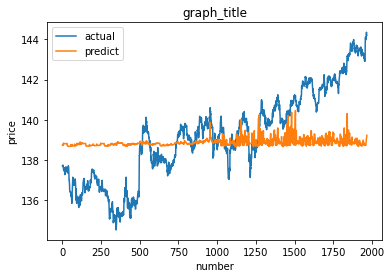

In [6]:
epochs = 15
graph_title = '1h'
y_pred_1h, y_pred = learn(df, X_train, 'y_rate_1h', 'graph_title', epochs, './model/GBPJPY_1h/model.hdf5','./model/GBPJPY_1h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1968
列数: 18
整形前の形状(特徴量): (1968, 18)
形状(特徴量): (1968, 18, 1)
形状(目的変数): (1968, 1)
モデルの学習を開始します
Epoch 1/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0582 - mae: 0.1990 - val_loss: 0.2176 - val_mae: 0.4648
Epoch 2/15
1908/1908 [==============================] - 3s 2ms/step - loss: 0.0522 - mae: 0.1887 - val_loss: 0.1846 - val_mae: 0.4281
Epoch 3/15
1908/1908 [==============================] - 3s 2ms/step - loss: 0.1305 - mae: 0.2902 - val_loss: 0.8314 - val_mae: 0.9110
Epoch 4/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.2577 - mae: 0.4590 - val_loss: 0.8314 - val_mae: 0.9110
Epoch 5/15
1908/1908 [==============================] - 3s 2ms/step - loss: 0.2528 - mae: 0.4521

<Figure size 432x288 with 0 Axes>

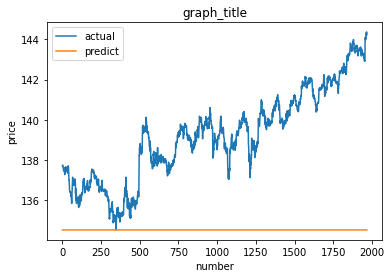

In [7]:
epochs = 15
graph_title = '2h'
y_pred_2h, y_pred = learn(df, X_train, 'y_rate_2h', 'graph_title', epochs, './model/GBPJPY_2h/model.hdf5','./model/GBPJPY_2h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1968
列数: 18
整形前の形状(特徴量): (1968, 18)
形状(特徴量): (1968, 18, 1)
形状(目的変数): (1968, 1)
モデルの学習を開始します
Epoch 1/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0548 - mae: 0.1890 - val_loss: 0.1870 - val_mae: 0.4305
Epoch 2/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0479 - mae: 0.1791 - val_loss: 0.1727 - val_mae: 0.4136
Epoch 3/15
1908/1908 [==============================] - 5s 2ms/step - loss: 0.0458 - mae: 0.1737 - val_loss: 0.8250 - val_mae: 0.9074
Epoch 4/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.2650 - mae: 0.4653 - val_loss: 0.8250 - val_mae: 0.9074
Epoch 5/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.2513 - mae: 0.4535

<Figure size 432x288 with 0 Axes>

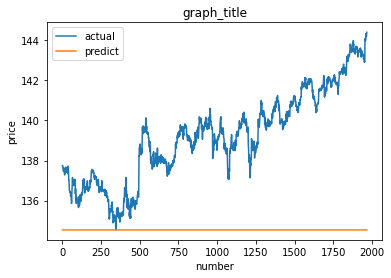

In [8]:
epochs = 15
graph_title = '3h'
y_pred_3h, y_pred = learn(df, X_train, 'y_rate_3h', 'graph_title', epochs, './model/GBPJPY_3h/model.hdf5','./model/GBPJPY_3h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1968
列数: 18
整形前の形状(特徴量): (1968, 18)
形状(特徴量): (1968, 18, 1)
形状(目的変数): (1968, 1)
モデルの学習を開始します
Epoch 1/15
1908/1908 [==============================] - 7s 3ms/step - loss: 0.0714 - mae: 0.2100 - val_loss: 0.2210 - val_mae: 0.4678
Epoch 2/15
1908/1908 [==============================] - 6s 3ms/step - loss: 0.0502 - mae: 0.1822 - val_loss: 0.2964 - val_mae: 0.5429
Epoch 3/15
1908/1908 [==============================] - 6s 3ms/step - loss: 0.0512 - mae: 0.1879 - val_loss: 0.4213 - val_mae: 0.6470
Epoch 4/15
1908/1908 [==============================] - 9s 4ms/step - loss: 0.0855 - mae: 0.2226 - val_loss: 0.5070 - val_mae: 0.7105
Epoch 5/15
1908/1908 [==============================] - 6s 3ms/step - loss: 0.1061 - mae: 0.2651

<Figure size 432x288 with 0 Axes>

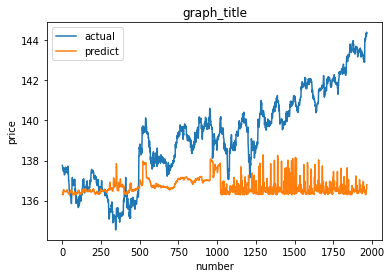

In [9]:
epochs = 15
graph_title = '4h'
y_pred_4h, y_pred = learn(df, X_train, 'y_rate_4h', 'graph_title', epochs, './model/GBPJPY_4h/model.hdf5','./model/GBPJPY_4h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1968
列数: 18
整形前の形状(特徴量): (1968, 18)
形状(特徴量): (1968, 18, 1)
形状(目的変数): (1968, 1)
モデルの学習を開始します
Epoch 1/15
1908/1908 [==============================] - 5s 2ms/step - loss: 0.0603 - mae: 0.1980 - val_loss: 0.1275 - val_mae: 0.3541
Epoch 2/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0490 - mae: 0.1816 - val_loss: 0.1485 - val_mae: 0.3830
Epoch 3/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0495 - mae: 0.1820 - val_loss: 0.1757 - val_mae: 0.4179
Epoch 4/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.2302 - mae: 0.4234 - val_loss: 0.8314 - val_mae: 0.9109
Epoch 5/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.2739 - mae: 0.4761

<Figure size 432x288 with 0 Axes>

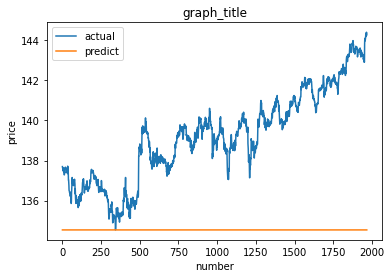

In [10]:
epochs = 15
graph_title = '5h'
y_pred_5h, y_pred = learn(df, X_train, 'y_rate_5h', 'graph_title', epochs, './model/GBPJPY_5h/model.hdf5','./model/GBPJPY_5h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1968
列数: 18
整形前の形状(特徴量): (1968, 18)
形状(特徴量): (1968, 18, 1)
形状(目的変数): (1968, 1)
モデルの学習を開始します
Epoch 1/15
1908/1908 [==============================] - 6s 2ms/step - loss: 0.0607 - mae: 0.1949 - val_loss: 0.1329 - val_mae: 0.3621
Epoch 2/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0501 - mae: 0.1823 - val_loss: 0.3102 - val_mae: 0.5553
Epoch 3/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0473 - mae: 0.1770 - val_loss: 0.8339 - val_mae: 0.9121
Epoch 4/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.2574 - mae: 0.4587 - val_loss: 0.8348 - val_mae: 0.9126
Epoch 5/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.2490 - mae: 0.4459

<Figure size 432x288 with 0 Axes>

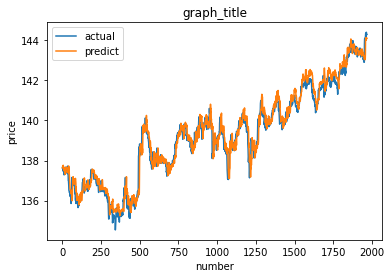

In [11]:
epochs = 15
graph_title = '6h'
y_pred_6h, y_pred = learn(df, X_train, 'y_rate_6h', 'graph_title', epochs, './model/GBPJPY_6h/model.hdf5','./model/GBPJPY_6h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1968
列数: 18
整形前の形状(特徴量): (1968, 18)
形状(特徴量): (1968, 18, 1)
形状(目的変数): (1968, 1)
モデルの学習を開始します
Epoch 1/15
1908/1908 [==============================] - 5s 2ms/step - loss: 0.0650 - mae: 0.2044 - val_loss: 0.2751 - val_mae: 0.5227
Epoch 2/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0512 - mae: 0.1833 - val_loss: 0.3313 - val_mae: 0.5737
Epoch 3/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0509 - mae: 0.1850 - val_loss: 0.1997 - val_mae: 0.4445
Epoch 4/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0496 - mae: 0.1815 - val_loss: 0.2063 - val_mae: 0.4520
Epoch 5/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.1736 - mae: 0.3461

<Figure size 432x288 with 0 Axes>

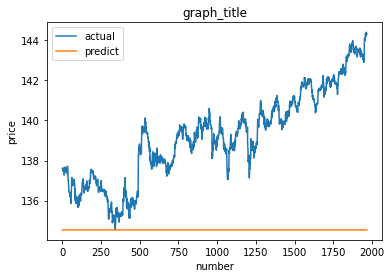

In [12]:
epochs = 15
graph_title = '7h'
y_pred_7h, y_pred = learn(df, X_train, 'y_rate_7h', 'graph_title', epochs, './model/GBPJPY_7h/model.hdf5','./model/GBPJPY_7h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1968
列数: 18
整形前の形状(特徴量): (1968, 18)
形状(特徴量): (1968, 18, 1)
形状(目的変数): (1968, 1)
モデルの学習を開始します
Epoch 1/15
1908/1908 [==============================] - 5s 2ms/step - loss: 25.0529 - mae: 0.6860 - val_loss: 0.6577 - val_mae: 0.8090
Epoch 2/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.1656 - mae: 0.3483 - val_loss: 0.6291 - val_mae: 0.7911
Epoch 3/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.1490 - mae: 0.3255 - val_loss: 0.5289 - val_mae: 0.7246
Epoch 4/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0995 - mae: 0.2585 - val_loss: 0.2296 - val_mae: 0.4724
Epoch 5/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0510 - mae: 0.184

<Figure size 432x288 with 0 Axes>

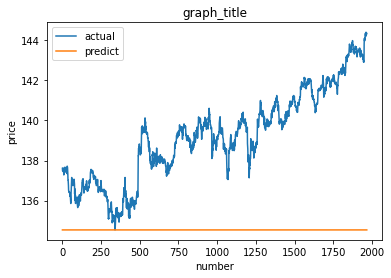

In [13]:
epochs = 15
graph_title = '8h'
y_pred_8h, y_pred = learn(df, X_train, 'y_rate_8h', 'graph_title', epochs, './model/GBPJPY_8h/model.hdf5','./model/GBPJPY_8h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1968
列数: 18
整形前の形状(特徴量): (1968, 18)
形状(特徴量): (1968, 18, 1)
形状(目的変数): (1968, 1)
モデルの学習を開始します
Epoch 1/15
1908/1908 [==============================] - 5s 2ms/step - loss: 0.0561 - mae: 0.1932 - val_loss: 0.2171 - val_mae: 0.4635
Epoch 2/15
1908/1908 [==============================] - 5s 2ms/step - loss: 0.0477 - mae: 0.1792 - val_loss: 0.2019 - val_mae: 0.4468
Epoch 3/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0645 - mae: 0.2002 - val_loss: 0.2697 - val_mae: 0.5165
Epoch 4/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0435 - mae: 0.1683 - val_loss: 0.2631 - val_mae: 0.5092
Epoch 5/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0390 - mae: 0.1599

<Figure size 432x288 with 0 Axes>

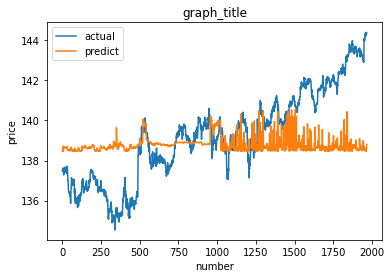

In [14]:
epochs = 15
graph_title = '9h'
y_pred_9h, y_pred = learn(df, X_train, 'y_rate_9h', 'graph_title', epochs, './model/GBPJPY_9h/model.hdf5','./model/GBPJPY_9h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1968
列数: 18
整形前の形状(特徴量): (1968, 18)
形状(特徴量): (1968, 18, 1)
形状(目的変数): (1968, 1)
モデルの学習を開始します
Epoch 1/15
1908/1908 [==============================] - 6s 2ms/step - loss: 0.0620 - mae: 0.1999 - val_loss: 0.2278 - val_mae: 0.4749
Epoch 2/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0507 - mae: 0.1857 - val_loss: 0.2376 - val_mae: 0.4851
Epoch 3/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0496 - mae: 0.1807 - val_loss: 0.2793 - val_mae: 0.5263
Epoch 4/15
1908/1908 [==============================] - 4s 2ms/step - loss: 105.0140 - mae: 3.4997 - val_loss: 0.8466 - val_mae: 0.9189
Epoch 5/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.2617 - mae: 0.46

<Figure size 432x288 with 0 Axes>

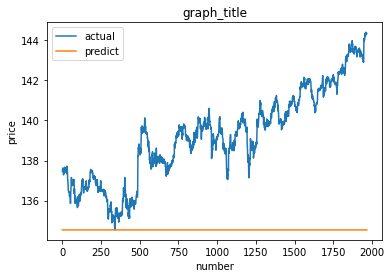

In [15]:
epochs = 15
graph_title = '10h'
y_pred_10h, y_pred = learn(df, X_train, 'y_rate_10h', 'graph_title', epochs, './model/GBPJPY_10h/model.hdf5','./model/GBPJPY_10h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1968
列数: 18
整形前の形状(特徴量): (1968, 18)
形状(特徴量): (1968, 18, 1)
形状(目的変数): (1968, 1)
モデルの学習を開始します
Epoch 1/15
1908/1908 [==============================] - 6s 2ms/step - loss: 0.0481 - mae: 0.1706 - val_loss: 0.2505 - val_mae: 0.4980
Epoch 2/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0263 - mae: 0.1315 - val_loss: 0.0085 - val_mae: 0.0700
Epoch 3/15
1908/1908 [==============================] - ETA: 0s - loss: 0.0248 - mae: 0.125 - 4s 2ms/step - loss: 0.0248 - mae: 0.1255 - val_loss: 0.0050 - val_mae: 0.0537
Epoch 4/15
1908/1908 [==============================] - 5s 3ms/step - loss: 0.0166 - mae: 0.1046 - val_loss: 0.0210 - val_mae: 0.1336
Epoch 5/15
1908/1908 [==============================] - 4s

<Figure size 432x288 with 0 Axes>

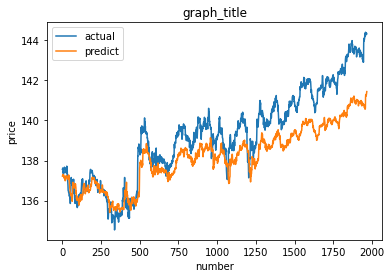

In [16]:
epochs = 15
graph_title = '11h'
y_pred_11h, y_pred = learn(df, X_train, 'y_rate_11h', 'graph_title', epochs, './model/GBPJPY_11h/model.hdf5','./model/GBPJPY_11h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1968
列数: 18
整形前の形状(特徴量): (1968, 18)
形状(特徴量): (1968, 18, 1)
形状(目的変数): (1968, 1)
モデルの学習を開始します
Epoch 1/15
1908/1908 [==============================] - 5s 2ms/step - loss: 0.0576 - mae: 0.1934 - val_loss: 0.2450 - val_mae: 0.4918
Epoch 2/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0507 - mae: 0.1847 - val_loss: 0.1828 - val_mae: 0.4250
Epoch 3/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.2156 - mae: 0.4029 - val_loss: 0.8524 - val_mae: 0.9219
Epoch 4/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.2575 - mae: 0.4590 - val_loss: 0.8524 - val_mae: 0.9219
Epoch 5/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.2633 - mae: 0.4648

<Figure size 432x288 with 0 Axes>

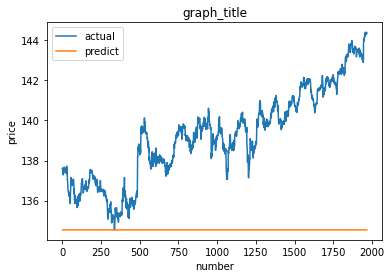

In [17]:
epochs = 15
graph_title = '12h'
y_pred_12h, y_pred = learn(df, X_train, 'y_rate_12h', 'graph_title', epochs, './model/GBPJPY_12h/model.hdf5','./model/GBPJPY_12h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1968
列数: 18
整形前の形状(特徴量): (1968, 18)
形状(特徴量): (1968, 18, 1)
形状(目的変数): (1968, 1)
モデルの学習を開始します
Epoch 1/15
1908/1908 [==============================] - 5s 2ms/step - loss: 0.0547 - mae: 0.1882 - val_loss: 0.1880 - val_mae: 0.4305
Epoch 2/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0490 - mae: 0.1804 - val_loss: 0.2977 - val_mae: 0.5434
Epoch 3/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0974 - mae: 0.2461 - val_loss: 0.8397 - val_mae: 0.9150
Epoch 4/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.2564 - mae: 0.4576 - val_loss: 0.8397 - val_mae: 0.9150
Epoch 5/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.2547 - mae: 0.4565

<Figure size 432x288 with 0 Axes>

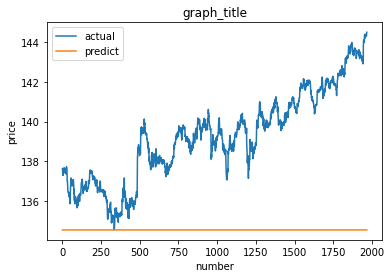

In [18]:
epochs = 15
graph_title = '13h'
y_pred_13h, y_pred = learn(df, X_train, 'y_rate_13h', 'graph_title', epochs, './model/GBPJPY_13h/model.hdf5','./model/GBPJPY_13h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1968
列数: 18
整形前の形状(特徴量): (1968, 18)
形状(特徴量): (1968, 18, 1)
形状(目的変数): (1968, 1)
モデルの学習を開始します
Epoch 1/15
1908/1908 [==============================] - 5s 2ms/step - loss: 0.0556 - mae: 0.1896 - val_loss: 0.1934 - val_mae: 0.4368
Epoch 2/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0481 - mae: 0.1788 - val_loss: 0.1943 - val_mae: 0.4377
Epoch 3/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0465 - mae: 0.1738 - val_loss: 0.2518 - val_mae: 0.4994
Epoch 4/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0429 - mae: 0.1651 - val_loss: 0.2411 - val_mae: 0.4876
Epoch 5/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0423 - mae: 0.1665

<Figure size 432x288 with 0 Axes>

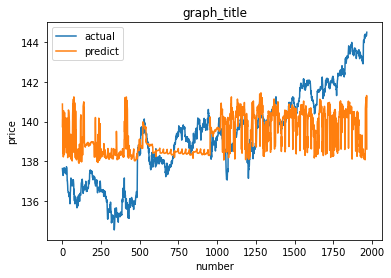

In [19]:
epochs = 15
graph_title = '14h'
y_pred_14h, y_pred = learn(df, X_train, 'y_rate_13h', 'graph_title', epochs, './model/GBPJPY_14h/model.hdf5','./model/GBPJPY_14h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1968
列数: 18
整形前の形状(特徴量): (1968, 18)
形状(特徴量): (1968, 18, 1)
形状(目的変数): (1968, 1)
モデルの学習を開始します
Epoch 1/15
1908/1908 [==============================] - 5s 2ms/step - loss: 0.0556 - mae: 0.1913 - val_loss: 0.2847 - val_mae: 0.5305
Epoch 2/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0471 - mae: 0.1789 - val_loss: 0.2123 - val_mae: 0.4578
Epoch 3/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0621 - mae: 0.2005 - val_loss: 0.8048 - val_mae: 0.8956
Epoch 4/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.2315 - mae: 0.4321 - val_loss: 0.8048 - val_mae: 0.8956
Epoch 5/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.2404 - mae: 0.4419

<Figure size 432x288 with 0 Axes>

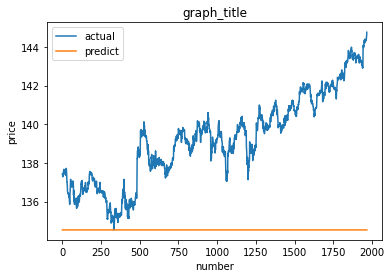

In [20]:
epochs = 15
graph_title = '15h'
y_pred_15h, y_pred = learn(df, X_train, 'y_rate_15h', 'graph_title', epochs, './model/GBPJPY_15h/model.hdf5','./model/GBPJPY_15h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1968
列数: 18
整形前の形状(特徴量): (1968, 18)
形状(特徴量): (1968, 18, 1)
形状(目的変数): (1968, 1)
モデルの学習を開始します
Epoch 1/15
1908/1908 [==============================] - 5s 2ms/step - loss: 0.0598 - mae: 0.1969 - val_loss: 0.2419 - val_mae: 0.4890
Epoch 2/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0484 - mae: 0.1797 - val_loss: 0.2451 - val_mae: 0.4921
Epoch 3/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0449 - mae: 0.1743 - val_loss: 0.2414 - val_mae: 0.4882
Epoch 4/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.1532 - mae: 0.2673 - val_loss: 0.7967 - val_mae: 0.8910
Epoch 5/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.2356 - mae: 0.4370

<Figure size 432x288 with 0 Axes>

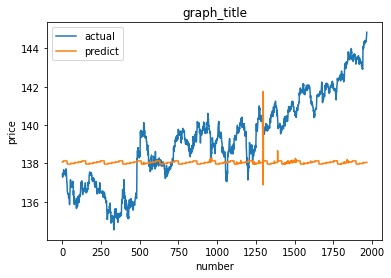

In [21]:
epochs = 15
graph_title = '16h'
y_pred_16h, y_pred = learn(df, X_train, 'y_rate_16h', 'graph_title', epochs, './model/GBPJPY_16h/model.hdf5','./model/GBPJPY_16h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1968
列数: 18
整形前の形状(特徴量): (1968, 18)
形状(特徴量): (1968, 18, 1)
形状(目的変数): (1968, 1)
モデルの学習を開始します
Epoch 1/15
1908/1908 [==============================] - 5s 2ms/step - loss: 0.0827 - mae: 0.2249 - val_loss: 0.2445 - val_mae: 0.4886
Epoch 2/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0500 - mae: 0.1825 - val_loss: 0.1434 - val_mae: 0.3752
Epoch 3/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0520 - mae: 0.1823 - val_loss: 0.2177 - val_mae: 0.4604
Epoch 4/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0461 - mae: 0.1723 - val_loss: 0.1108 - val_mae: 0.3283
Epoch 5/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0494 - mae: 0.1815

<Figure size 432x288 with 0 Axes>

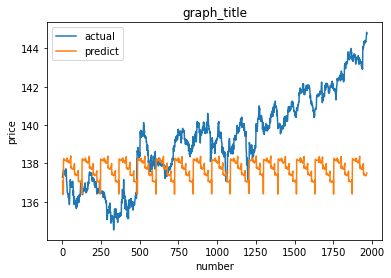

In [22]:
epochs = 15
graph_title = '17h'
y_pred_17h, y_pred = learn(df, X_train, 'y_rate_17h', 'graph_title', epochs, './model/GBPJPY_17h/model.hdf5','./model/GBPJPY_17h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1968
列数: 18
整形前の形状(特徴量): (1968, 18)
形状(特徴量): (1968, 18, 1)
形状(目的変数): (1968, 1)
モデルの学習を開始します
Epoch 1/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0538 - mae: 0.1869 - val_loss: 0.1672 - val_mae: 0.4052
Epoch 2/15
1908/1908 [==============================] - 3s 2ms/step - loss: 0.0464 - mae: 0.1745 - val_loss: 0.2836 - val_mae: 0.5295
Epoch 3/15
1908/1908 [==============================] - 3s 2ms/step - loss: 0.0477 - mae: 0.1800 - val_loss: 0.6493 - val_mae: 0.8010
Epoch 4/15
1908/1908 [==============================] - 3s 2ms/step - loss: 0.0630 - mae: 0.2017 - val_loss: 0.2353 - val_mae: 0.4816
Epoch 5/15
1908/1908 [==============================] - 3s 2ms/step - loss: 0.0398 - mae: 0.1610

<Figure size 432x288 with 0 Axes>

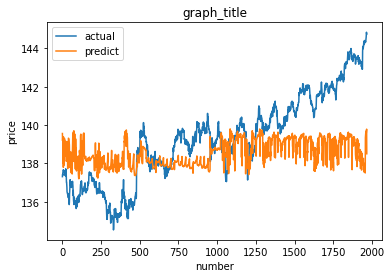

In [58]:
epochs = 15
graph_title = '18h'
y_pred_18h, y_pred = learn(df, X_train, 'y_rate_18h', 'graph_title', epochs, './model/GBPJPY_18h/model.hdf5','./model/GBPJPY_18h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1968
列数: 18
整形前の形状(特徴量): (1968, 18)
形状(特徴量): (1968, 18, 1)
形状(目的変数): (1968, 1)
モデルの学習を開始します
Epoch 1/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0596 - mae: 0.1949 - val_loss: 0.2013 - val_mae: 0.4438
Epoch 2/15
1908/1908 [==============================] - 3s 2ms/step - loss: 0.0429 - mae: 0.1654 - val_loss: 0.0060 - val_mae: 0.0555
Epoch 3/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0069 - mae: 0.0660 - val_loss: 0.0048 - val_mae: 0.0558
Epoch 4/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0066 - mae: 0.0641 - val_loss: 0.0909 - val_mae: 0.2891
Epoch 5/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0077 - mae: 0.0674

<Figure size 432x288 with 0 Axes>

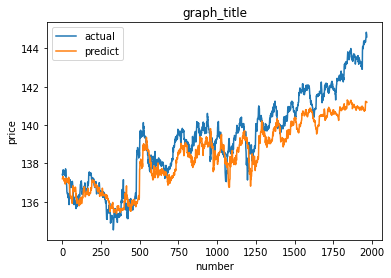

In [24]:
epochs = 15
graph_title = '19h'
y_pred_19h, y_pred = learn(df, X_train, 'y_rate_19h', 'graph_title', epochs, './model/GBPJPY_19h/model.hdf5','./model/GBPJPY_19h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1968
列数: 18
整形前の形状(特徴量): (1968, 18)
形状(特徴量): (1968, 18, 1)
形状(目的変数): (1968, 1)
モデルの学習を開始します
Epoch 1/15
1908/1908 [==============================] - 5s 2ms/step - loss: 0.0566 - mae: 0.1912 - val_loss: 0.2528 - val_mae: 0.4985
Epoch 2/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0496 - mae: 0.1818 - val_loss: 0.1737 - val_mae: 0.4121
Epoch 3/15
1908/1908 [==============================] - ETA: 0s - loss: 0.0478 - mae: 0.178 - 4s 2ms/step - loss: 0.0479 - mae: 0.1786 - val_loss: 0.3323 - val_mae: 0.5708
Epoch 4/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0410 - mae: 0.1623 - val_loss: 0.2088 - val_mae: 0.4519
Epoch 5/15
1908/1908 [==============================] - 4s

<Figure size 432x288 with 0 Axes>

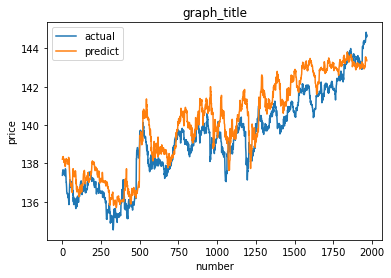

In [25]:
epochs = 15
graph_title = '20h'
y_pred_20h, y_pred = learn(df, X_train, 'y_rate_20h', 'graph_title', epochs, './model/GBPJPY_20h/model.hdf5','./model/GBPJPY_20h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1968
列数: 18
整形前の形状(特徴量): (1968, 18)
形状(特徴量): (1968, 18, 1)
形状(目的変数): (1968, 1)
モデルの学習を開始します
Epoch 1/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0518 - mae: 0.1853 - val_loss: 0.2539 - val_mae: 0.5005
Epoch 2/15
1908/1908 [==============================] - 3s 2ms/step - loss: 0.0459 - mae: 0.1755 - val_loss: 0.2209 - val_mae: 0.4662
Epoch 3/15
1908/1908 [==============================] - 3s 2ms/step - loss: 0.0792 - mae: 0.2104 - val_loss: 0.8149 - val_mae: 0.9008
Epoch 4/15
1908/1908 [==============================] - 3s 2ms/step - loss: 0.2425 - mae: 0.4452 - val_loss: 0.8149 - val_mae: 0.9008
Epoch 5/15
1908/1908 [==============================] - 3s 2ms/step - loss: 0.2429 - mae: 0.4441

<Figure size 432x288 with 0 Axes>

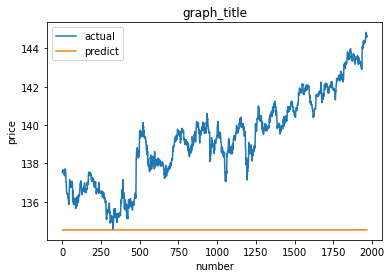

In [57]:
epochs = 15
graph_title = '21h'
y_pred_21h, y_pred = learn(df, X_train, 'y_rate_21h', 'graph_title', epochs, './model/GBPJPY_21h/model.hdf5','./model/GBPJPY_21h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1968
列数: 18
整形前の形状(特徴量): (1968, 18)
形状(特徴量): (1968, 18, 1)
形状(目的変数): (1968, 1)
モデルの学習を開始します
Epoch 1/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0445 - mae: 0.1689 - val_loss: 0.1292 - val_mae: 0.3532
Epoch 2/15
1908/1908 [==============================] - 3s 2ms/step - loss: 0.0186 - mae: 0.1090 - val_loss: 0.0507 - val_mae: 0.2151
Epoch 3/15
1908/1908 [==============================] - 3s 2ms/step - loss: 0.0170 - mae: 0.1056 - val_loss: 0.0126 - val_mae: 0.0899
Epoch 4/15
1908/1908 [==============================] - 3s 2ms/step - loss: 0.0135 - mae: 0.0927 - val_loss: 0.0453 - val_mae: 0.2011
Epoch 5/15
1908/1908 [==============================] - 3s 2ms/step - loss: 0.0094 - mae: 0.0761

<Figure size 432x288 with 0 Axes>

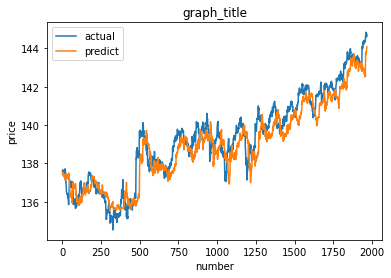

In [45]:
epochs = 15
graph_title = '22h'
y_pred_22h, y_pred = learn(df, X_train, 'y_rate_22h', 'graph_title', epochs, './model/GBPJPY_22h/model.hdf5','./model/GBPJPY_22h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1968
列数: 18
整形前の形状(特徴量): (1968, 18)
形状(特徴量): (1968, 18, 1)
形状(目的変数): (1968, 1)
モデルの学習を開始します
Epoch 1/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0575 - mae: 0.1969 - val_loss: 0.1438 - val_mae: 0.3742
Epoch 2/15
1908/1908 [==============================] - 3s 2ms/step - loss: 0.0485 - mae: 0.1795 - val_loss: 0.2537 - val_mae: 0.5000
Epoch 3/15
1908/1908 [==============================] - 3s 2ms/step - loss: 0.1097 - mae: 0.2602 - val_loss: 0.8067 - val_mae: 0.8957
Epoch 4/15
1908/1908 [==============================] - 3s 2ms/step - loss: 0.2141 - mae: 0.4102 - val_loss: 0.7611 - val_mae: 0.8683
Epoch 5/15
1908/1908 [==============================] - 3s 2ms/step - loss: 0.1631 - mae: 0.3426

<Figure size 432x288 with 0 Axes>

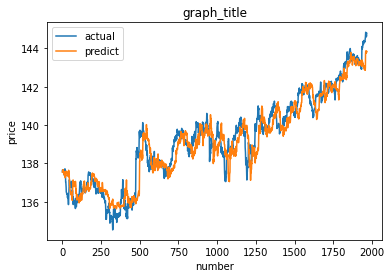

In [48]:
epochs = 15
graph_title = '23h'
y_pred_23h, y_pred = learn(df, X_train, 'y_rate_23h', 'graph_title', epochs, './model/GBPJPY_23h/model.hdf5','./model/GBPJPY_23h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1968
列数: 18
整形前の形状(特徴量): (1968, 18)
形状(特徴量): (1968, 18, 1)
形状(目的変数): (1968, 1)
モデルの学習を開始します
Epoch 1/15
1908/1908 [==============================] - 4s 2ms/step - loss: 0.0548 - mae: 0.1921 - val_loss: 0.1199 - val_mae: 0.3417
Epoch 2/15
1908/1908 [==============================] - 3s 2ms/step - loss: 0.0479 - mae: 0.1767 - val_loss: 0.2819 - val_mae: 0.5271
Epoch 3/15
1908/1908 [==============================] - 3s 2ms/step - loss: 0.0478 - mae: 0.1777 - val_loss: 0.1853 - val_mae: 0.4252
Epoch 4/15
1908/1908 [==============================] - 3s 2ms/step - loss: 0.0122 - mae: 0.0872 - val_loss: 0.0240 - val_mae: 0.1416
Epoch 5/15
1908/1908 [==============================] - 3s 2ms/step - loss: 0.0079 - mae: 0.0713

<Figure size 432x288 with 0 Axes>

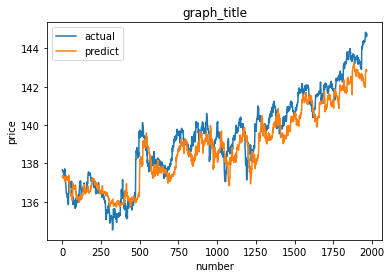

In [38]:
epochs = 15
graph_title = '24h'
y_pred_24h, y_pred = learn(df, X_train, 'y_rate_24h', 'graph_title', epochs, './model/GBPJPY_24h/model.hdf5','./model/GBPJPY_24h/param.hdf5') # 学習関数


[[139.10355385]
 [134.537     ]
 [134.53707069]
 [136.5738485 ]
 [134.53700008]
 [144.13180279]
 [134.537     ]
 [134.53700173]
 [138.5846395 ]
 [134.537     ]
 [141.41337995]
 [134.537     ]
 [134.537     ]
 [141.3088461 ]
 [134.537     ]
 [138.04549945]
 [137.46071169]
 [134.537     ]
 [141.21674788]
 [143.41191906]
 [134.537     ]
 [140.75925176]
 [138.34680706]
 [134.537     ]]


<Figure size 432x288 with 0 Axes>

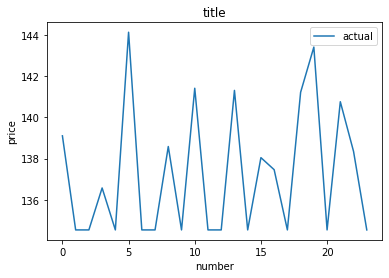

In [30]:
plot_list = np.concatenate([y_pred_1h, y_pred_2h, y_pred_3h, y_pred_4h, y_pred_5h, y_pred_6h, y_pred_7h, y_pred_8h
                           , y_pred_9h, y_pred_10h, y_pred_11h, y_pred_12h, y_pred_13h, y_pred_14h, y_pred_15h, y_pred_16h
                           , y_pred_17h, y_pred_18h, y_pred_19h, y_pred_20h, y_pred_21h, y_pred_22h, y_pred_23h, y_pred_24h])# 5m, 1h, 4h, 8h, 1dの予測リスト

def plot_pred(plot_list):
    flg = plt.figure()
    fig = plt.figure(figsize=(6, 4), dpi=72, linewidth=10)
    ax = fig.add_subplot(111, xlabel='number', ylabel='price',title='title')  # グラフ作成
    
    ax.plot(plot_list, label='actual')  # 5m, 1h, 4h, 8h, 1dの予測リスト
   # ax.plot(y_pred, label='predict')  # 予測
    plt.legend()

plot_pred(plot_list)
print(plot_list)

In [31]:
a = df['y_rate_2h'].tolist() # Tolistを使う予定

y = a - y_pred


In [32]:
print(len(a))
print(len(y_pred))
print(len(y))


1968
1968
1968
